### ARMA Linear Representation

In [108]:
ILLUS_PATH <- 'D:/Softwares/GitHub/Discrete-SV-Models-Estimation/Code/Illustration'

In [109]:
sv_simul_can <- function(theta, log_h0){
    epsilon <- c()
    log_h <- c()
    omega <- theta[1]
    beta <- theta[2]
    sigma <- theta[3]
    eta <- rnorm(T, 0, 1)
    nu <- rnorm(T, 0, 1)
    
    log_h[1] <- omega + beta * log_h0 + sigma * nu[1]
    epsilon[1] <- sqrt(exp(log_h[1])) * eta[1]
    
    for (t in 2:T){
        log_h[t] <- omega + beta * log_h[t-1] + sigma * nu[t]
        epsilon[t] <- sqrt(exp(log_h[t])) * eta[t]
    }
    list(epsilon, log_h)
}

In [110]:
# Inputs
# omega <- -0.736
# beta <- 0.9
# sigma <- 0.363

omega <- 0
beta <- 0.99
sigma <- 0.2

theta <- c(omega, beta, sigma)
log_h0 <- omega
T <- 10000

In [111]:
set.seed(123)
data <- sv_simul_can(theta, log_h0)
epsilon <- unlist(data[1])
log_h <- unlist(data[2])

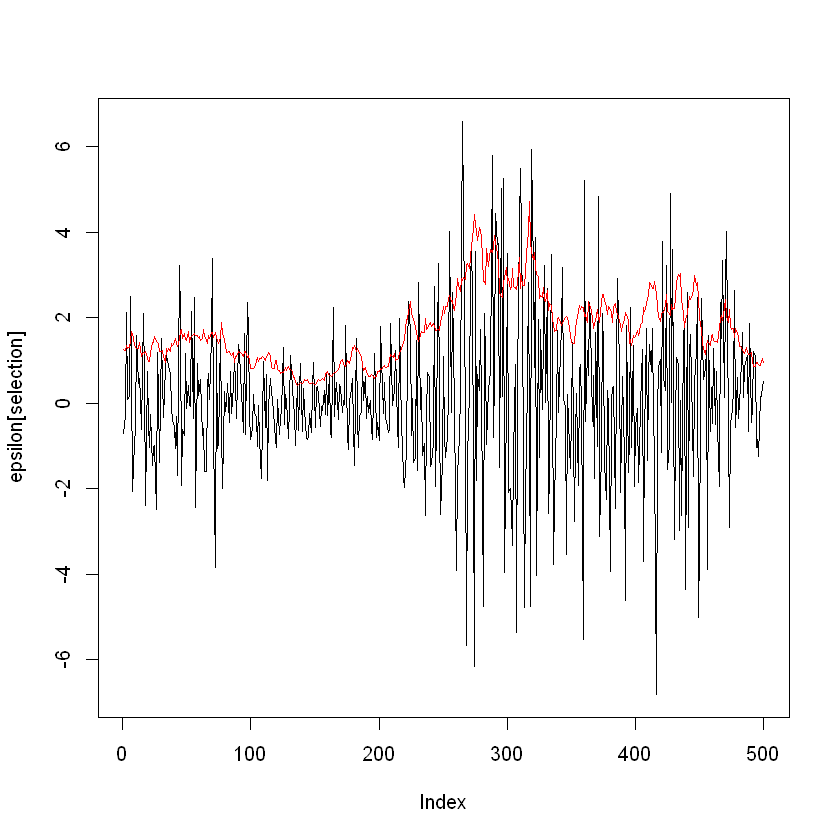

In [112]:
selection <- 1:500
plot(epsilon[selection], type='l', col='black')
lines(sqrt(exp(log_h))[selection], type='l', col='red')

##### Pre-calculation of the Kalman Filter quantities

In [113]:
obj_sv <- function(theta, epsilon){
    alpha_t <- c()
    P_t <- c()
    F_t <- c()
    K_t <- c()
    omega <- theta[1]
    beta <- theta[2]
    sigma <- theta[3]
    mu_Z <- -1.270
    sigma_Z <- sqrt(pi**2/2)
    
    a0 <- 0
    beta0 <- 0.8
    P0 <- sigma**2
    F0 <- P0 + sigma_Z**2
    
    T <- length(epsilon)
    y_t <- log(epsilon**2)
    
    alpha_t[1] <- beta0 * a0 + omega
    P_t[1] <- beta**2 * P0 + sigma**2
    K_t[1] <- beta * P0 * 1/F0
    
    for (t in 2:T){
        F_t[t-1] <- P_t[t-1] + sigma_Z**2
        K_t[t] <- beta * P_t[t-1] * 1/F_t[t-1]
        alpha_t[t] <- beta * alpha_t[t-1] + K_t[t] *
            (y_t[t-1] - alpha_t[t-1] - mu_Z) + omega
        P_t[t] <- beta**2 * P_t[t-1] - K_t[t]**2 * F_t[t-1] + sigma**2
    }
    F_t[T] <- P_t[T-1] + sigma_Z**2
    qml <- -T/2 * log(2*pi) - 1/2*sum(log(F_t) +
        (log(epsilon**2) - alpha_t - mu_Z)**2 / F_t)
    -qml
}

In [114]:
estim_sv <- function(theta0, epsilon){
    valinit <- theta0
    lower <- c(-Inf, 0, 0)
    upper <- c(Inf, 0.999, Inf)
    res <- nlminb(valinit, obj_sv, lower=lower,
                  upper=upper, epsilon=epsilon)
    theta_hat <- res$par[1:3]
    theta_hat
}

In [115]:
# Estimation Inputs
omega0 <- -0.6
beta0 <- 0.9
sigma0 <- 0.5
theta0 <- c(omega0, beta0, sigma0)

In [116]:
estimation <- estim_sv(theta0, epsilon)
theta_hat <- estimation
theta_hat
theta

[1] -0.002185773  0.988377174  0.199121406

[1] 0.00 0.99 0.20

  ####  SV Estimation Motne Carlo

In [117]:
M <- 1000

In [118]:
omega_spread <- c()
beta_spread <- c()
sigma_spread <- c()

for (j in 1:M){
    results <- sv_simul_can(theta, log_h0)
    epsilon <- unlist(results[1])
    estimation <- estim_sv(theta0, epsilon)
    theta_hat <- estimation
    omega_hat <- theta_hat[1]
    beta_hat <- theta_hat[2]
    sigma_hat <- theta_hat[3]
    omega_spread[j] <- omega_hat - omega
    beta_spread[j] <- beta_hat - beta
    sigma_spread[j] <- sigma_hat - sigma
}

### Table

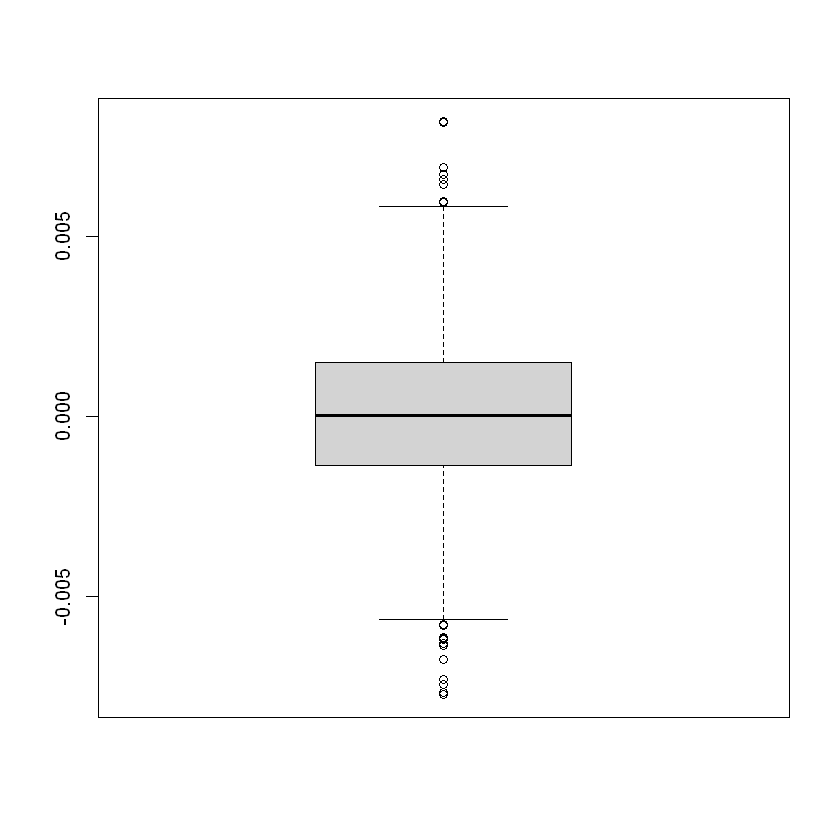

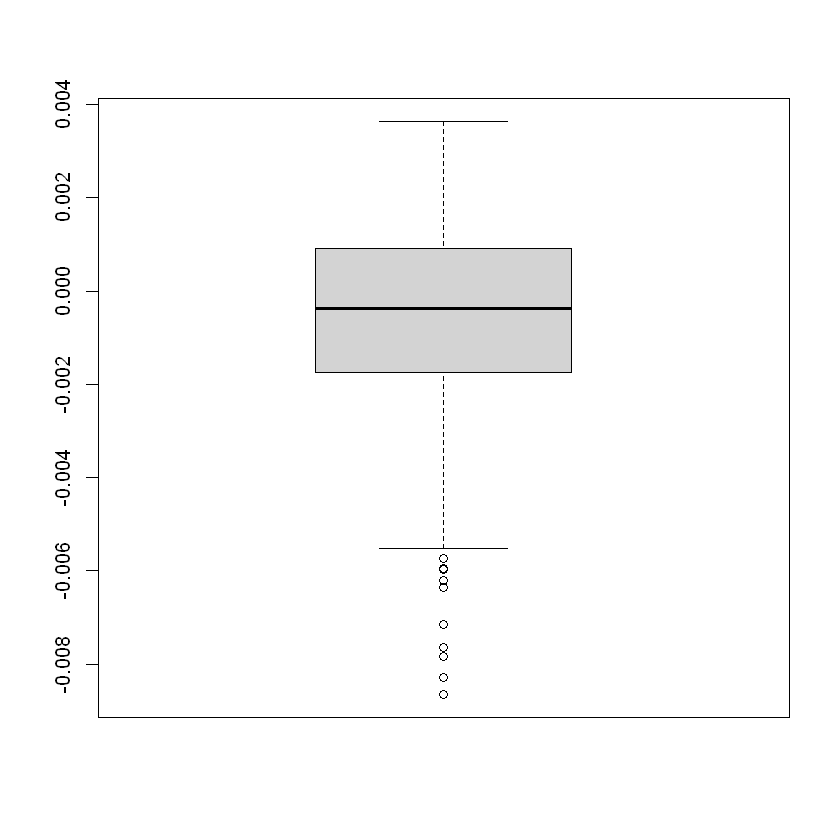

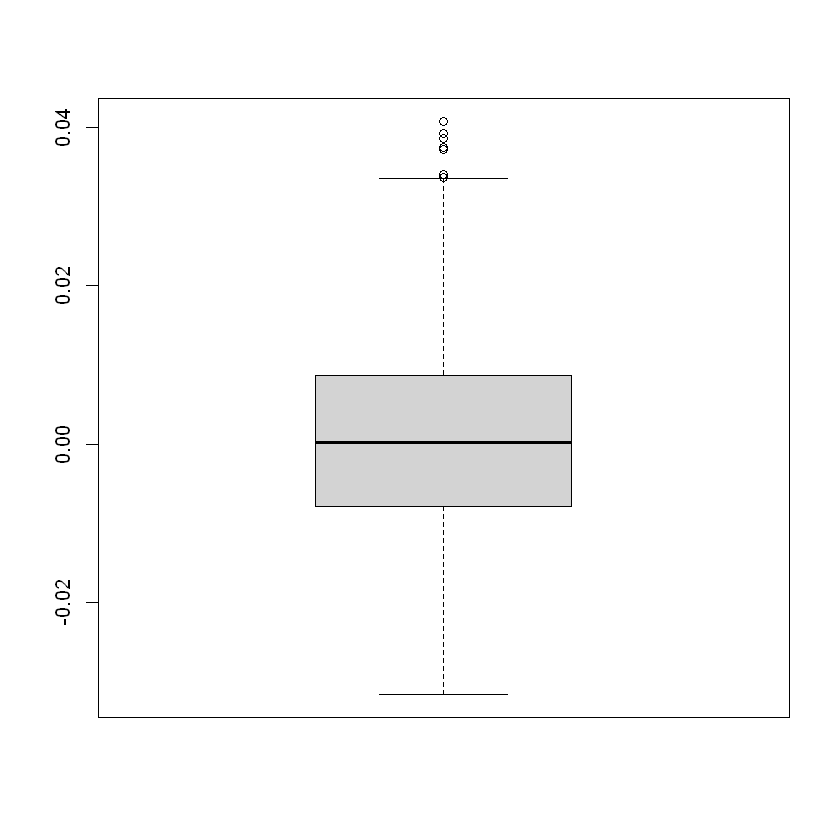

In [119]:
boxplot(omega_spread)
boxplot(beta_spread)
boxplot(sigma_spread)

In [120]:
mean(omega_spread)
mean(beta_spread)
mean(sigma_spread)

[1] 6.484835e-05

[1] -0.0005412239

[1] 0.0006202337

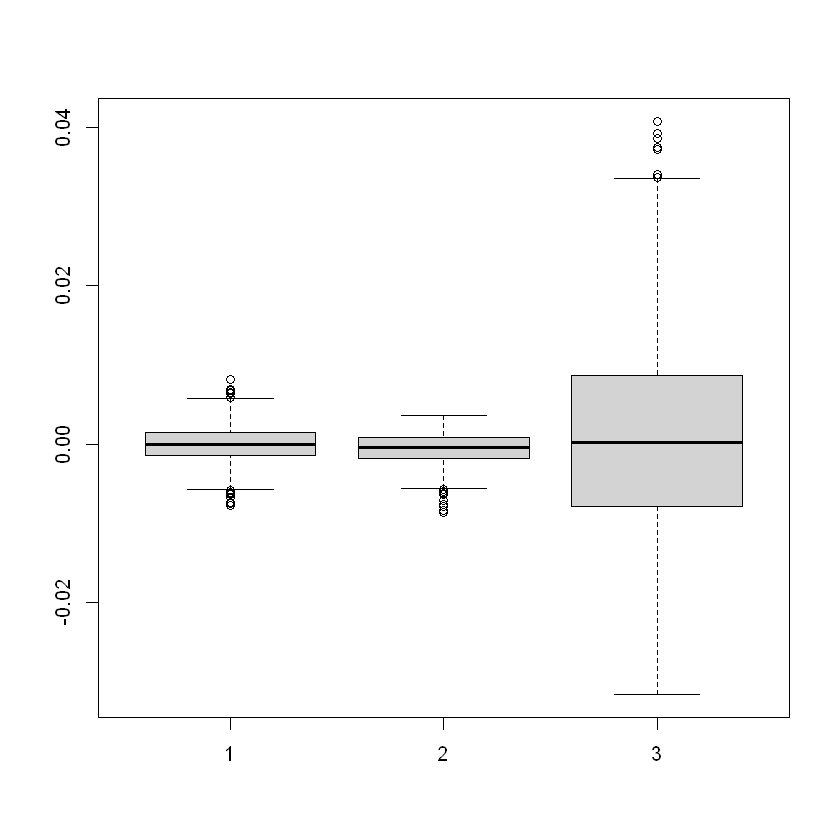

In [121]:
boxplot(omega_spread, beta_spread, sigma_spread)

In [122]:
spread_conso <- matrix(0, nrow=M, ncol=3)
spread_conso[,1] <- omega_spread
spread_conso[,2] <- beta_spread
spread_conso[,3] <- sigma_spread

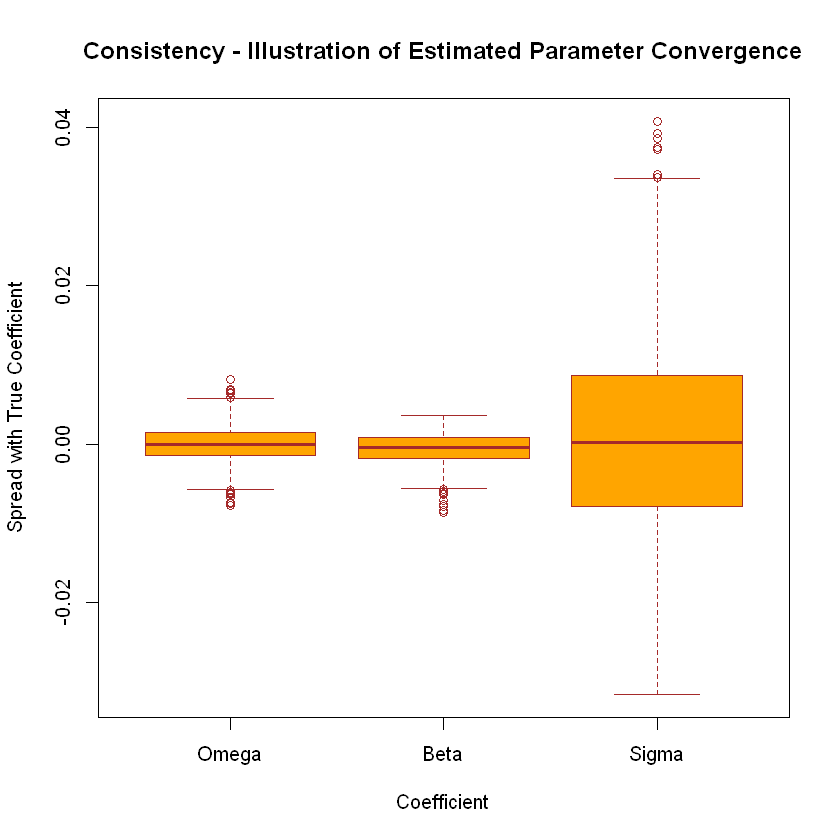

In [123]:
boxplot(spread_conso,
names=c("Omega","Beta","Sigma"),
data=airquality,
main="Consistency - Illustration of Estimated Parameter Convergence",
xlab="Coefficient",
ylab="Spread with True Coefficient",
col="orange",
border="brown"
)

In [124]:
pdf(file=paste0(ILLUS_PATH, "boxplot_QML.pdf"),width=10, height=5)
boxplot(spread_conso,
names=c("Omega","Beta","Sigma"),
data=airquality,
main="Consistency - Illustration of Estimated Parameter Convergence",
xlab="Coefficient",
ylab="Spread with True Coefficient",
col="orange",
border="brown"
)
dev.off()

png 
  2

In [125]:
spread_conso_bis <- matrix(0, nrow=M, ncol=3)
spread_conso_bis[,1] <- sqrt(T) * omega_spread
spread_conso_bis[,2] <- sqrt(T) * beta_spread
spread_conso_bis[,3] <- sqrt(T) * sigma_spread

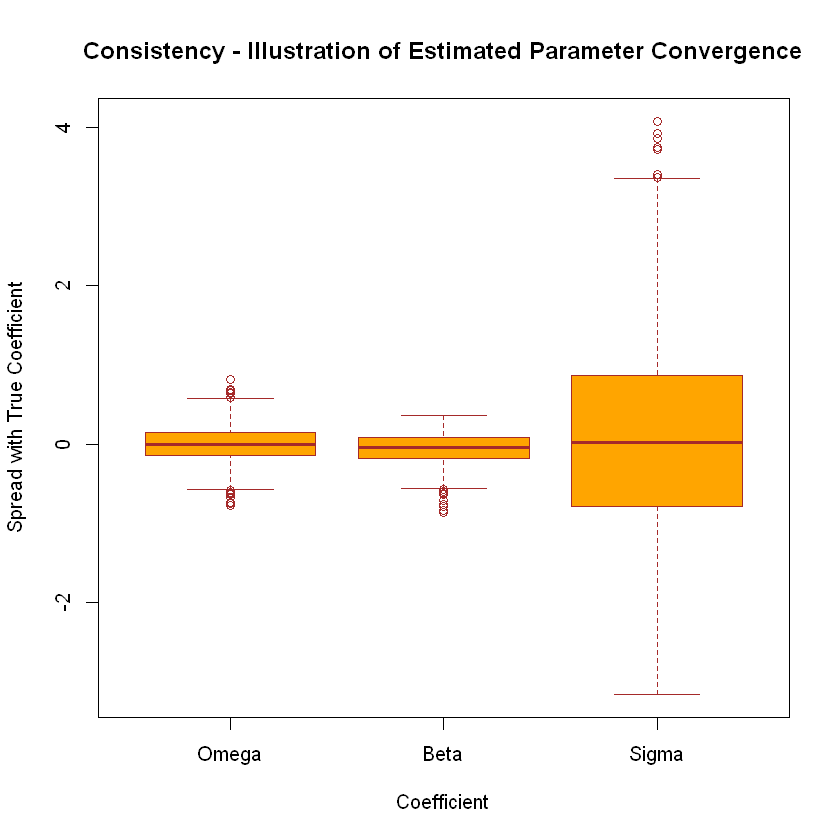

In [126]:
boxplot(spread_conso_bis,
names=c("Omega","Beta","Sigma"),
data=airquality,
main="Consistency - Illustration of Estimated Parameter Convergence",
xlab="Coefficient",
ylab="Spread with True Coefficient",
col="orange",
border="brown"
)

In [127]:
T

[1] 10000

#### Present the data

In [128]:
theta_spread_conso <- matrix(0, nrow=3, ncol=M)
theta_spread_conso[1,] <- sqrt(T) * omega_spread
theta_spread_conso[2,] <- sqrt(T) * beta_spread
theta_spread_conso[3,] <- sqrt(T) * sigma_spread

In [129]:
write.csv(theta_spread_conso, paste0(ILLUS_PATH, "theta_spread_conso_10000.csv"))

In [158]:
length(theta_spread_conso_500[1,])
length(theta_spread_conso_1000[1,])
length(omega_conso[,2])

[1] 999

[1] 999

[1] 999

### Load the Data

In [186]:
theta_spread_conso_500 <- read.csv(paste0(ILLUS_PATH, 'theta_spread_conso_500.csv'))[,2:M]
theta_spread_conso_1000 <- read.csv(paste0(ILLUS_PATH, 'theta_spread_conso_1000.csv'))[,2:M]
theta_spread_conso_3000 <- read.csv(paste0(ILLUS_PATH, 'theta_spread_conso_3000.csv'))[,2:M]
theta_spread_conso_10000 <- read.csv(paste0(ILLUS_PATH, 'theta_spread_conso_10000.csv'))[,2:M]

In [215]:
omega_conso <- matrix(0, nrow=M-1, ncol=4)
omega_conso[,1] <- unlist(theta_spread_conso_500[1,])
omega_conso[,2] <- unlist(theta_spread_conso_1000[1,])
omega_conso[,3] <- unlist(theta_spread_conso_3000[1,])
omega_conso[,4] <- unlist(theta_spread_conso_10000[1,])

beta_conso <- matrix(0, nrow=M-1, ncol=4)
beta_conso[,1] <- unlist(theta_spread_conso_500[2,])
beta_conso[,2] <- unlist(theta_spread_conso_1000[2,])
beta_conso[,3] <- unlist(theta_spread_conso_3000[2,])
beta_conso[,4] <- unlist(theta_spread_conso_10000[2,])

sigma_conso <- matrix(0, nrow=M-1, ncol=4)
sigma_conso[,1] <- unlist(theta_spread_conso_500[3,])
sigma_conso[,2] <- unlist(theta_spread_conso_1000[3,])
sigma_conso[,3] <- unlist(theta_spread_conso_3000[3,])
sigma_conso[,4] <- unlist(theta_spread_conso_10000[3,])

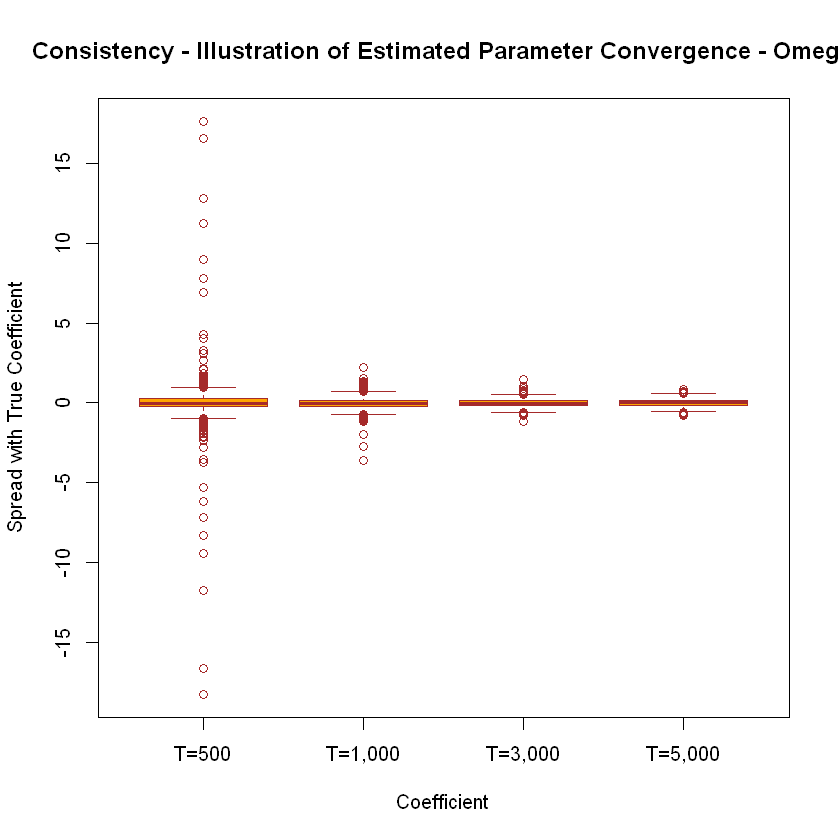

In [216]:
boxplot(omega_conso,
names=c("T=500","T=1,000","T=3,000", "T=5,000"),
data=airquality,
main="Consistency - Illustration of Estimated Parameter Convergence - Omega",
xlab="Coefficient",
ylab="Spread with True Coefficient",
col="orange",
border="brown"
)

In [217]:
pdf(file=paste0(ILLUS_PATH, "boxplot_omega.pdf"),width=10, height=5)
boxplot(omega_conso,
names=c("T=500","T=1,000","T=3,000", "T=5,000"),
data=airquality,
main="Consistency - Illustration of Estimated Parameter Convergence
omega",
xlab="Coefficient",
ylab="Spread with True Coefficient",
col="orange",
border="brown"
)
dev.off()

png 
  2

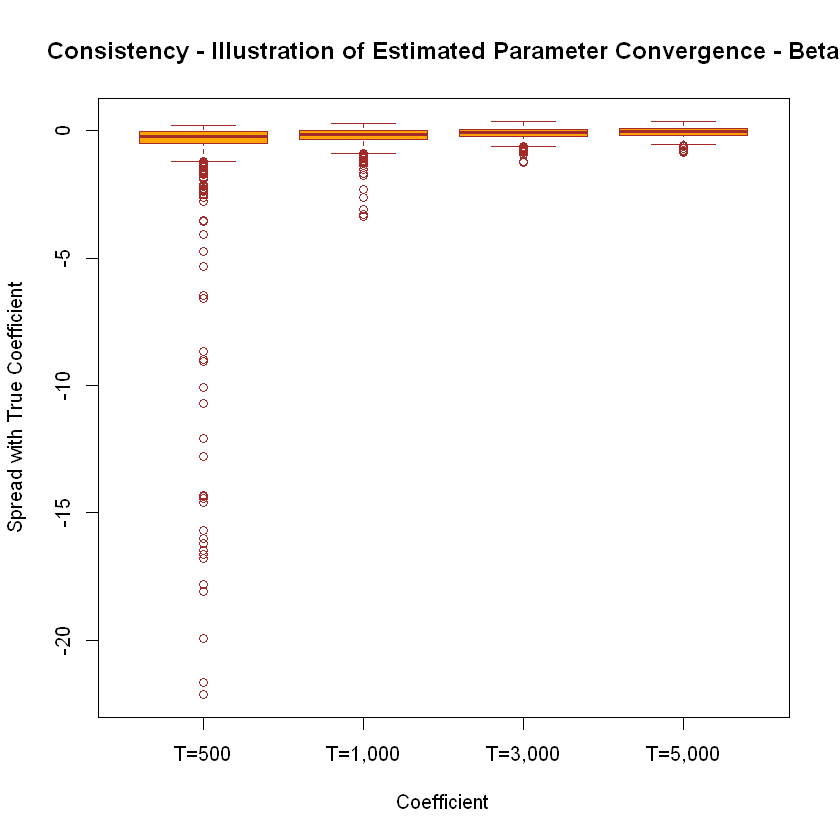

In [218]:
boxplot(beta_conso,
names=c("T=500","T=1,000","T=3,000", "T=5,000"),
data=airquality,
main="Consistency - Illustration of Estimated Parameter Convergence - Beta",
xlab="Coefficient",
ylab="Spread with True Coefficient",
col="orange",
border="brown"
)

In [219]:
pdf(file=paste0(ILLUS_PATH, "boxplot_beta.pdf"),width=10, height=5)
boxplot(beta_conso,
names=c("T=500","T=1,000","T=3,000", "T=5,000"),
data=airquality,
main="Consistency - Illustration of Estimated Parameter Convergence
beta",
xlab="Coefficient",
ylab="Spread with True Coefficient",
col="orange",
border="brown"
)
dev.off()

png 
  2

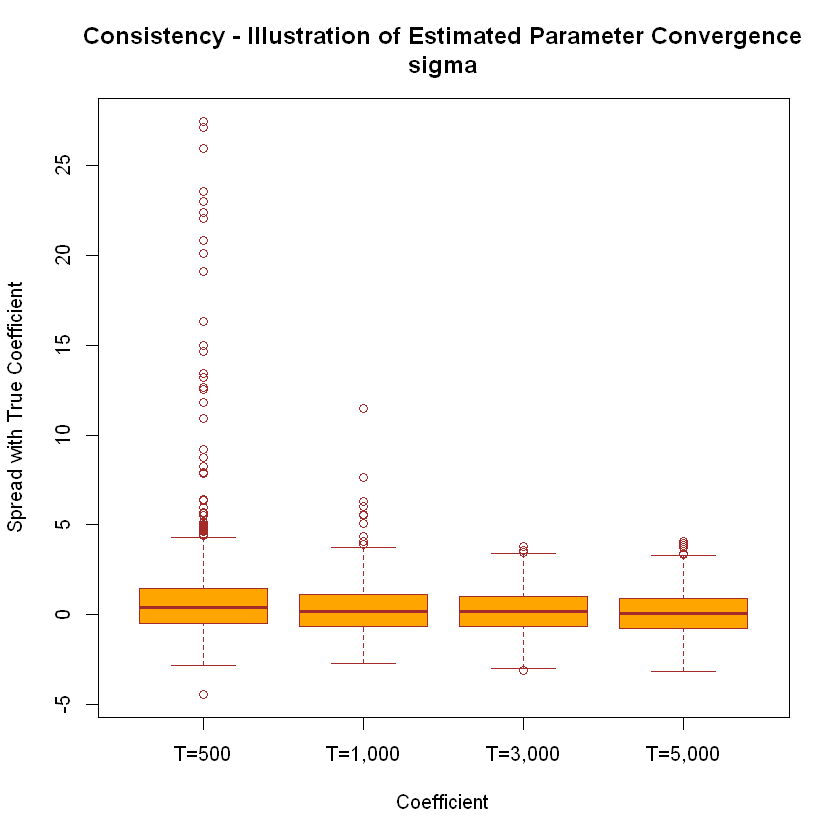

In [220]:
boxplot(sigma_conso,
names=c("T=500","T=1,000","T=3,000", "T=5,000"),
data=airquality,
main="Consistency - Illustration of Estimated Parameter Convergence
sigma",
xlab="Coefficient",
ylab="Spread with True Coefficient",
col="orange",
border="brown"
)

In [221]:
pdf(file=paste0(ILLUS_PATH, "boxplot_sigma.pdf"),width=10, height=5)
boxplot(sigma_conso,
names=c("T=500","T=1,000","T=3,000", "T=5,000"),
data=airquality,
main="Consistency - Illustration of Estimated Parameter Convergence
sigma",
xlab="Coefficient",
ylab="Spread with True Coefficient",
col="orange",
border="brown"
)
dev.off()

png 
  2